- Introducción:

    La presente libreta tiene como objetivo mostrar la implementación de diferentes algoritmos de Aprendizaje Supervisado y no Supervisado aplicados a la detección de anomalías. Particularmente, el objetivo principal .....

1. Carga de la librerias y la información.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### 2. Análisis exploratorio de datos. 

- El objetivo que se tiene es poder estimar la probabilidad de que una transacción sea fraudulenta a manera que la probabilidad sea alta cuando la variable binaria "isFraud" sea 1 y baja para caso contrario.


La información esta partida en las tablas: identity (train y test) y transaction (train y test), se pueden cruzar por TransactionID. **¡OJO! No todas las transacciones tienen información de identidad. ***  


2.1 Descripción y observación de los datos.

- La siguiente función tiene como objetivo permitir al usuario tener un resumen descriptivo del dataframe seleccionado, así como la observación de algunas de las entradas del mismo.

In [2]:
# Función para leer y hacer una primera revisión de los datos
def read_and_interpret_data(path = '', filename = ''):

    df = pd.read_csv('{0}{1}'.format(path,filename))
    print("~~~~~~Perfil de los datos~~~~~~ : ",df.shape)
    print("~~~~~~Columnas con su datatype~~~~~~ : ")
    print(df.info())
    print("~~~~~~Primeros datos~~~~~~ : ")
    print(df.head())
    print("~~~~~~Últimos datos~~~~~~ : ")
    print(df.tail())
    print("~~~~~~Descripción de los datos~~~~~~ : ")
    print(df.describe())
    print("~~~~~~Datos faltantes~~~~~~ : ")
    print(df.isna().sum())
    if 'timestamp' in df.columns: 
        df['timestamp'] = pd.to_datetime(df['timestamp'],format = "%Y-%m-%d %H:%M:%S")
        print("~~~~~~Años de los datos~~~~~~ :")
        print(df.timestamp.dt.year.unique())
    return df

El dataframe "identiy" contiene 41 variables con información de la conexión de red (IP, ISP, Proxy, etc.) y firma digital (UA/navegador/OS/versión, etc.) asociada con las transacciones. Dichos datos fueron recolectados por el sistema de protección contra fraudes de Vesta y los socios de seguridad digital.

 Las varaiblescategóricas son las siguientes:
 - DeviceType
 - DeviceInfo
 - id_12 a id_38


In [3]:
df_train_id = read_and_interpret_data('','creditcard.csv')

~~~~~~Perfil de los datos~~~~~~ :  (284807, 31)
~~~~~~Columnas con su datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19

2.2 Optimización del uso de memoria 

- Ante el enorme reto que significa modelar datasets cuya información ronda 1500MB, a continuación se define y posteriormente se aplica una función que permitira reducir el tamaño del formato default otorgado por pandas al cargar cada uno de los dataframes, esto con la finalidad de lograr una manipulación más sencilla y rápida de la información.

In [27]:
#Se procede a guardar cada uno de los datasets.
credit_fraud = pd.read_csv('creditcard.csv')

In [5]:
# Definición de la función para la reducción de uso de memoria
def reduce_mem_usage(df):
    ### itera a través de todas las columnas de un "dataframe" y modifica el tipo de datos
    ### para reducir el uso de la memoria.        ###
    # Se imprime el tamaño inicial del dataframe.
    start_mem = df.memory_usage().sum() / 1024**2
    print('El uso de memoria del "dataframe" es {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # Si el tipo de dato es númerico se reduce el espacio al mínimo tamaño posible que permite almacenar 
            # el dato más grande o pequeño de la columna
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
            #Si el tipo de dato es caracter, se transforma el tipo de dato a categoríco o categoría.
        else:
            df[col] = df[col].astype('category')
    # Se imprime el resultado final.
    end_mem = df.memory_usage().sum() / 1024**2
    print('El uso de memoria después de la optimización es: {:.2f} MB'.format(end_mem))
    print('Disminuido en {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
#Se aplica la función en los diversos dataframes definidos.
credit_fraud = reduce_mem_usage(credit_fraud)

El uso de memoria del "dataframe" es 67.36 MB
El uso de memoria después de la optimización es: 17.11 MB
Disminuido en 74.6%


2.3 Análisis de la información.

- A continuación se procede al análisis visual de la información, haciendo uso de diversos gráficos: histogramas, scatter plots o box plots. Con el objetivo de identificar patrones o características de población que nos ayuden a seleccionar el modelo más adecuado para nuestro problema.

In [22]:
list(credit_fraud.columns[[0, -2, -1]])

['Time', 'Amount', 'Class']

In [14]:
credit_fraud.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

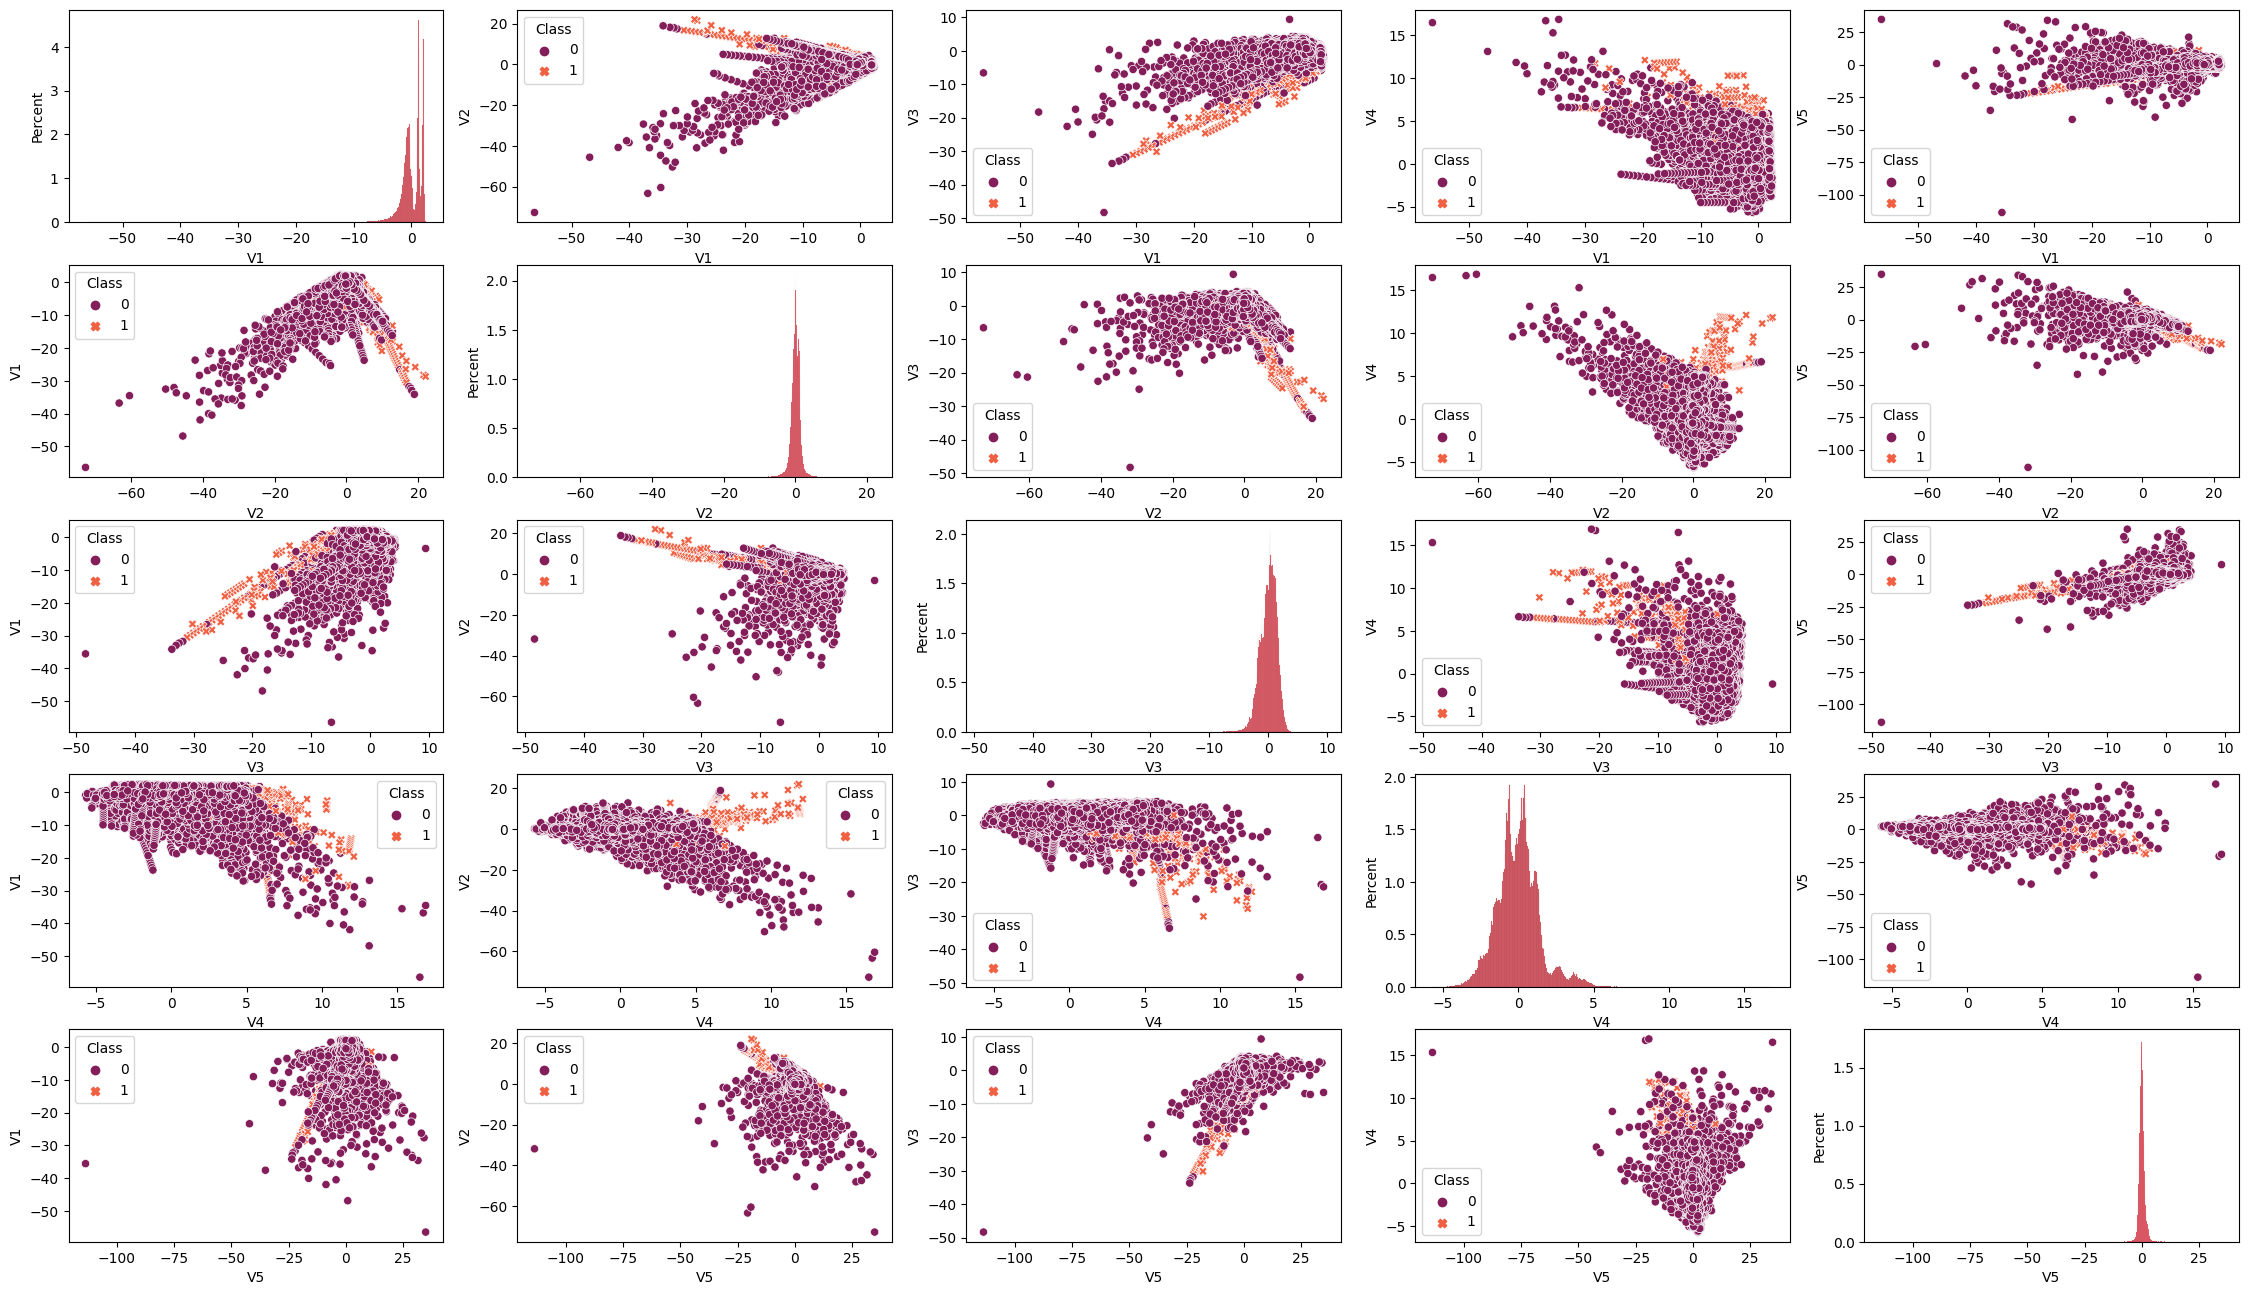

In [56]:
list_v = list(credit_fraud.columns[1:-3])
list_o = list(credit_fraud.columns[[0, -2, -1]])

fig, ax = plt.subplots(5,5, figsize=(28,16))
for i in range(5):
    for j in range(5):
        if i == j:
            sns.histplot(data=credit_fraud[[list_v[i]]], x=list_v[i],
                         stat= 'percent', color=sns.color_palette("rocket")[3], ax=ax[i,j])
        else:     
            sns.scatterplot(data=credit_fraud[[list_v[i], list_v[j], list_o[-1]]], x=list_v[i],
                             y= list_v[j], hue= list_o[-1], style= list_o[-1], palette= 'rocket',
                              ax=ax[i,j] )
        #ax[i//3,j].bar_label(ax[i//3,j].containers[0])
plt.show()

- Como era de esperarse el problema presenta en su varaible objetivo una  distribución totalmente desbalanceada donde solo el 3.5% de las operaciones fueron marcadas como fraudulentas.

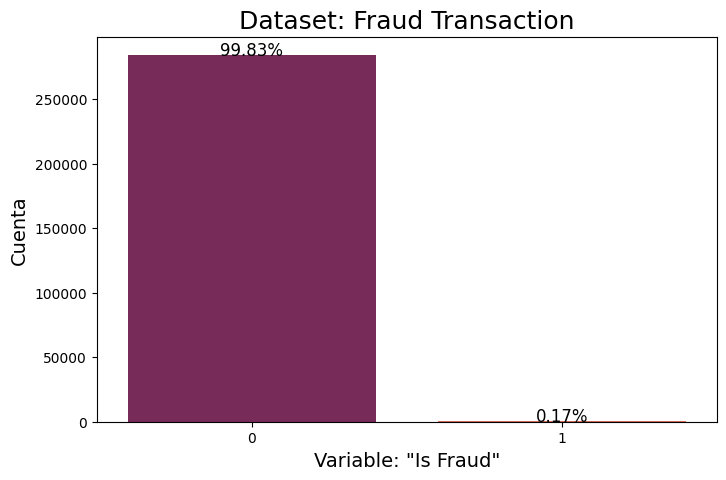

In [75]:
fig, ax  = plt.subplots(figsize=(8, 5))
sns.countplot(data = credit_fraud[[list_o[-1]]], x= list_o[-1], palette="rocket",
               ax=ax)
ax.set_title('Dataset: Fraud Transaction', fontsize=18)
ax.set_xlabel('Variable: "Is Fraud"', fontsize=14)
ax.set_ylabel('Cuenta', fontsize=14)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            f'{height/credit_fraud.shape[0] * 100:.2f}%',
            ha='center', fontsize=12)


In [78]:
list_o

['Time', 'Amount', 'Class']

- Con el objetivo de interpretar de manera más adecuada se suaviza los montos de las transacciones.

<Axes: xlabel='Time', ylabel='Count'>

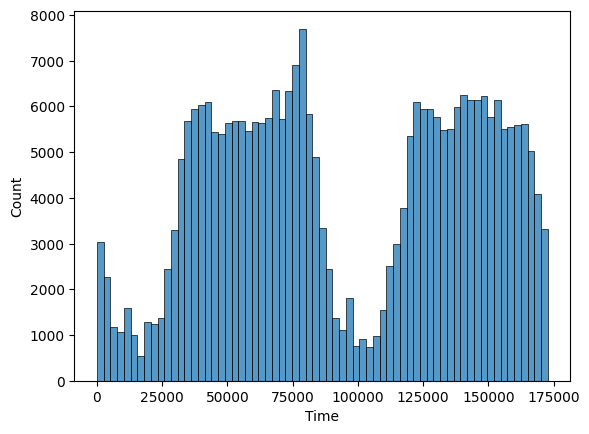

In [111]:
sns.histplot(data=credit_fraud, x= list_o[0])

<Axes: xlabel='Time', ylabel='Amount'>

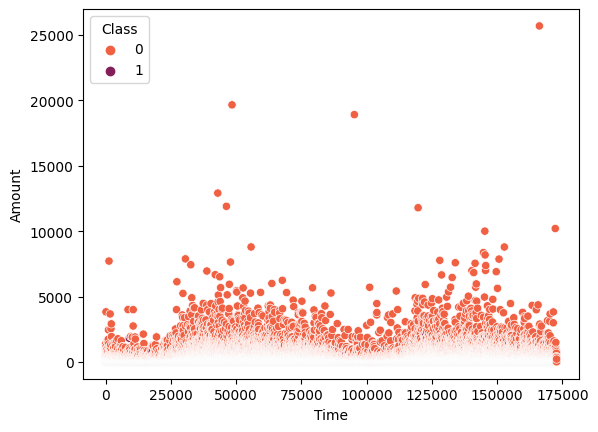

In [91]:
sns.scatterplot(data=credit_fraud, x=list_o[0],
                             y= list_o[1], hue= list_o[-1], palette='rocket_r')

Características de la tarjeta

- De acuerdo con la página de descripción de datos de la competencia, hay 6 características de tarjeta diferentes, card1 a card6. Sin embargo, card1, card2, card3 y card5 se codifican como valor numérico. No se nos dice el significado exacto de las características de las características de la tarjeta. Esta puede ser la información de la tarjeta de pago, como el tipo de tarjeta, la categoría de la tarjeta, etc.

- Muchos valores de card3 y card5 tienen frecuencias bajas.

- En la tarjeta 3, 150 y 185 son los valores más frecuentes en la columna. Tenemos 2.4% de fraude en 150 y 13% de fraude en valor 185

- En card5, los valores más frecuentes son 226, 224, 166 que representa el 73% de los datos.

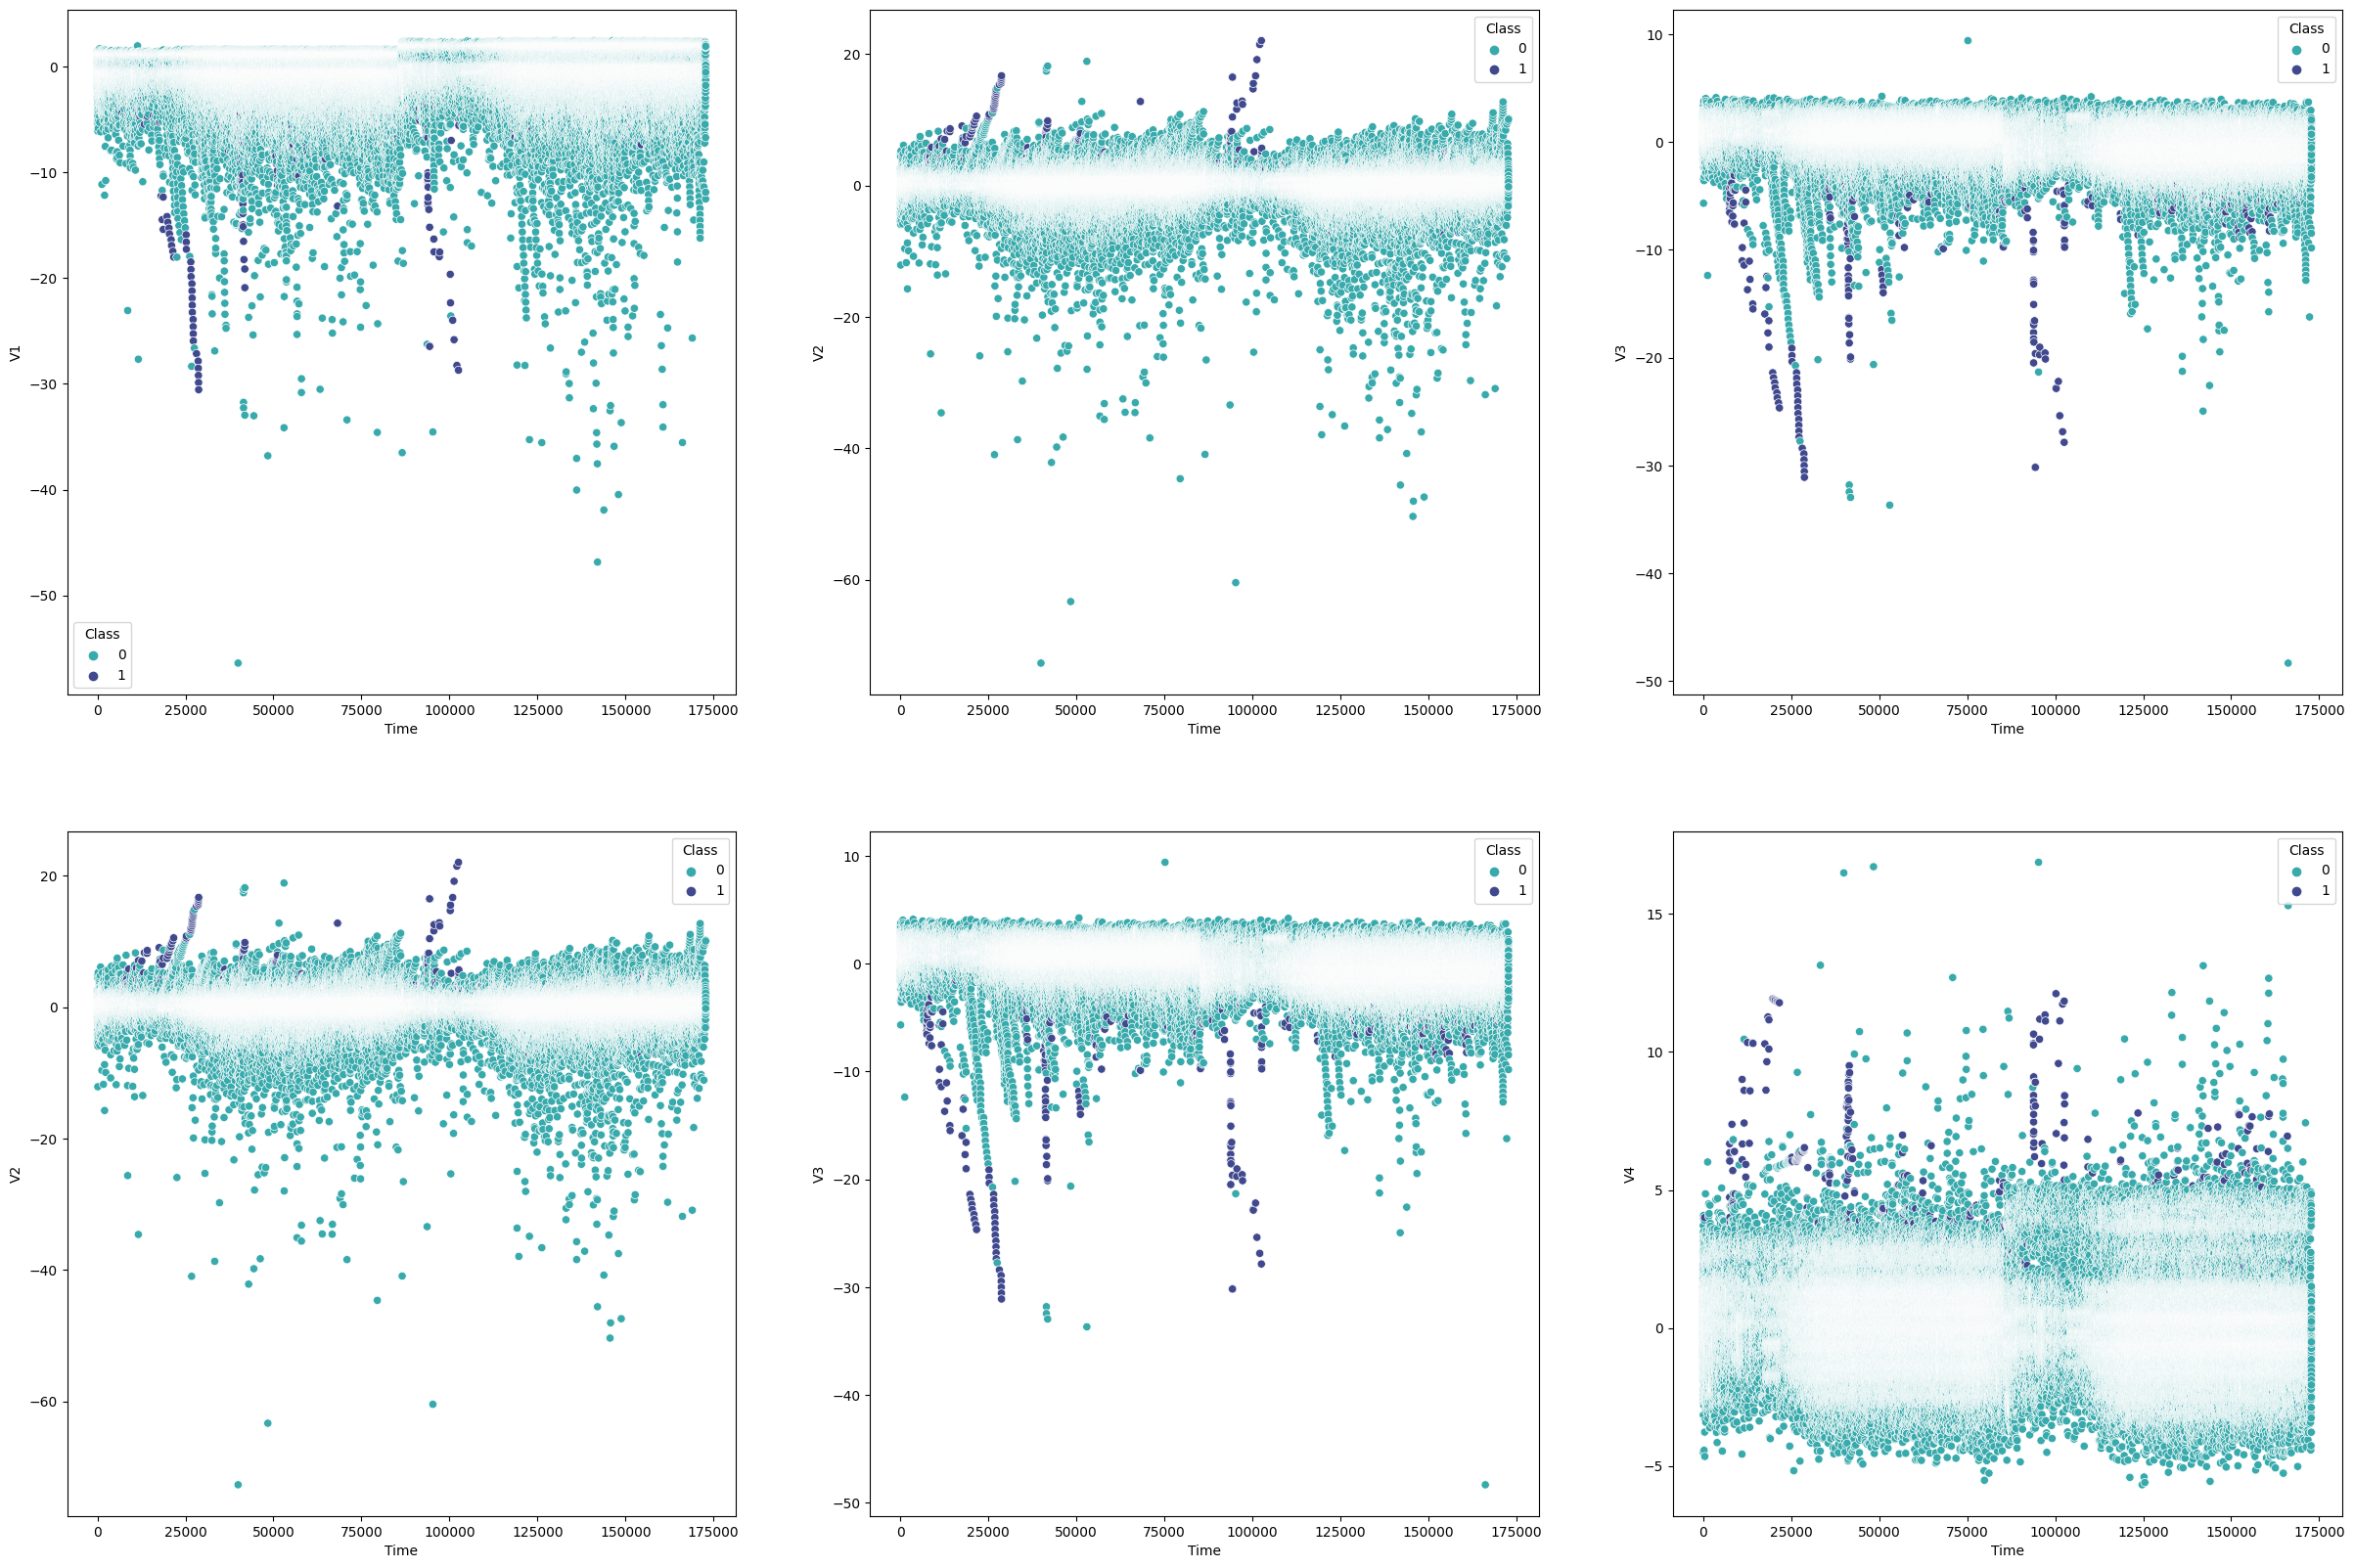

In [89]:
fig, ax = plt.subplots(2,3, figsize=(30, 20))
for i in range(2):
    for j in range(3):
        sns.scatterplot(data=credit_fraud[[list_o[0], list_v[i+j], list_o[-1]]], x=list_o[0],
                             y= list_v[i+j], hue= list_o[-1], palette= 'mako_r', ax=ax[i,j] )
    #ax[i].set_title("Distribución de "+(card))

In [105]:
len(credit_fraud.columns)

31

Características C1-C14
 - C1-C14: El significado real está enmascarado.

Excepto por C3, que tiene una cantidad significativamente menor que las otras características de C. El resto de las características de C exhiben el mismo tipo de patrones anuales. 

<Axes: >

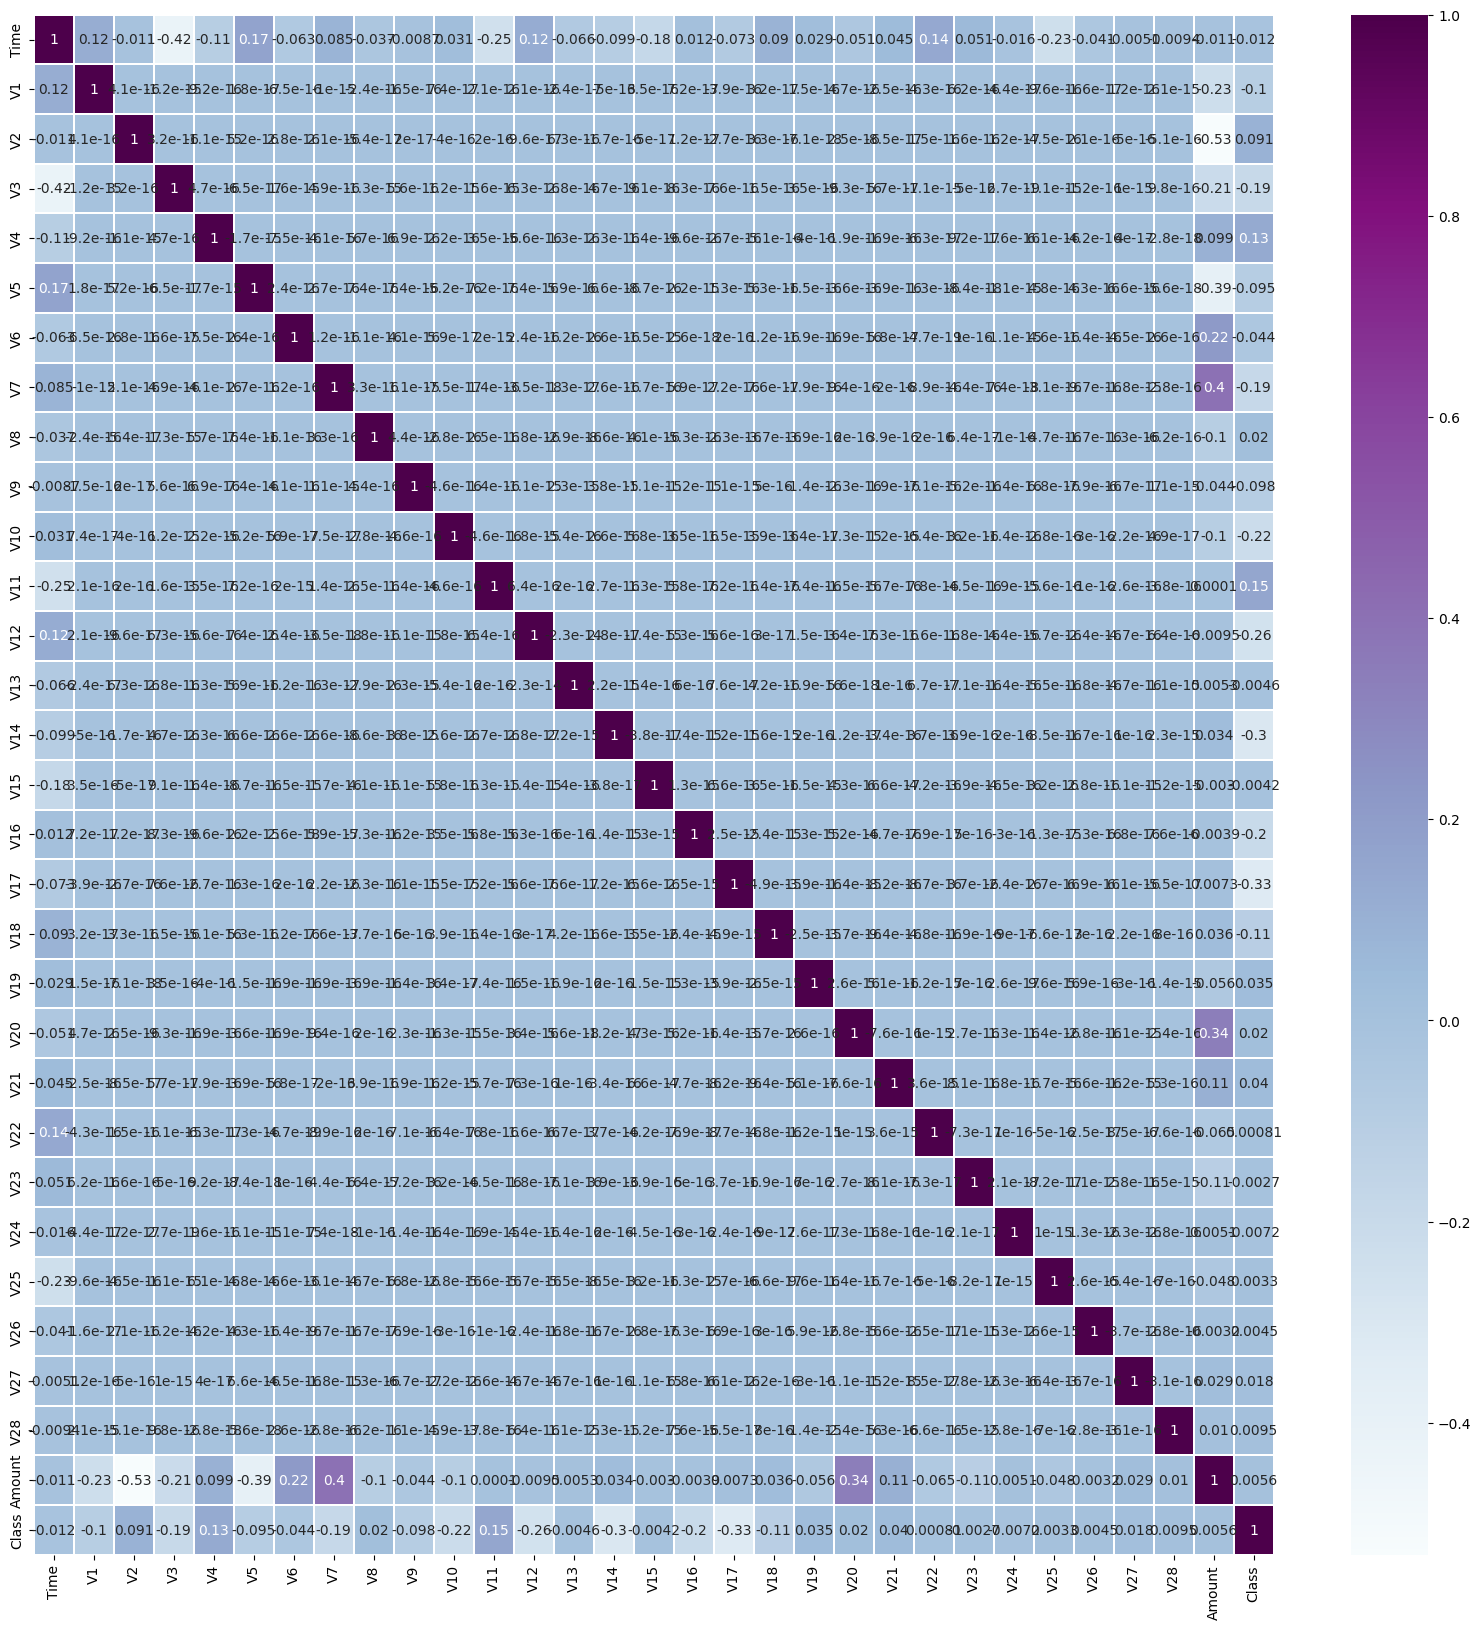

In [110]:
corr = credit_fraud.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, linewidths=.2, annot=True, ax=ax, cmap="BuPu")


#####
Derviado del Anpalsisi exploratorio, se procede a realizar la ingeniera de varaibles, 

1) Nos des-haremos de los outliers.
2) Estandarizaremos la linformación.


In [112]:
def aux_outliers(a,b,c):
    a=set(a)
    b=set(b)
    c=set(c)
    
    a_=a.intersection(b)

    b_=b.intersection(c)

    c_=a.intersection(c)

    outliers_index=list(set(list(a_)+list(b_)+list(c_)))
    return outliers_index


def OUTLIERS(df,cols):
    results=pd.DataFrame()
    data_iqr=df.copy()
    data_per=df.copy()
    total=[]
    total_per=[]
    total_z=[]
    indices_=[]

    for col in cols:
        #IQR
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        INF=Q1-1.5*(IQR)
        SUP=Q3+1.5*(IQR)
    
        
        n_outliers=df[(df[col] < INF) | (df[col] > SUP)].shape[0]
        total.append(n_outliers)
        indices_iqr=list(df[(df[col] < INF) | (df[col] > SUP)].index)
        #data_iqr=data_iqr[~(data_iqr[col] < INF) | (data_iqr[col] > SUP)].reset_index(drop=True)
        
        #Percentiles
        INF_pe=np.percentile(df[col].dropna(),1)
    
        SUP_pe=np.percentile(df[col].dropna(),99)
        n_outliers_per=df[(df[col] < INF_pe) | (df[col] > SUP_pe)].shape[0]
        total_per.append(n_outliers_per)
        indices_per=list(df[(df[col] < INF_pe) | (df[col] > SUP_pe)].index)
        #data_per=data_per[~(data_per[col] < INF_pe) | (data_per[col] > SUP_pe)].reset_index(drop=True)
        
        #MEAN CHANGE
        
        #Obtenemos todos los percentiles además del máximo
        perc_100 = [x / 100 for x in range(100)]
        dist = df[col].describe(perc_100).iloc[4:]
        #Obtenemos el cambio entre percentiles
        change_dist = df[col].describe(perc_100).iloc[4:].diff()
        #Obtenemos el cambio promedio entre percentiles
        mean_change = df[col].describe(
            perc_100).iloc[4:].diff().mean()
        #Si el cambio entre el percentil 99 y el maximo es mayor a el cambio promedio entonces:
        if change_dist["max"] > mean_change:
            #La banda superior será el máximo menos el cambio promedio
            ub = dist["max"] - mean_change
            #si la banda superior es más pequeña que el percentil 99 , modificamos la banda para que tome el percentil 99
            if ub < dist["99%"]:
                ub = dist["99%"]
        else:
        #Si el cambio entre el percentil 99 y el maximo es menor o igual a el cambio promedio entonces se toma el percentil 99
            ub = dist["max"]

        if change_dist["1%"] > mean_change:
            lb = dist["0%"] + mean_change
            if lb > dist["1%"]:
                lb = dist["1%"]
        else:
            lb = dist["0%"]
        n_total_z=df[(df[col] < lb) | (df[col] > ub)].shape[0]
        total_z.append(n_total_z)
        indices_z=list(df[(df[col] < lb) | (df[col] > ub)].index)
        
        indices_.append(aux_outliers(indices_iqr,indices_per,indices_z))
        
    results["features"]=cols
    results["n_outliers_IQR"]=total
    results["n_outliers_Percentil"]=total_per
    results["n_outliers_Mean_Change"]=total_z
    results["n_outliers_IQR_%"]=round((results["n_outliers_IQR"]/df.shape[0])*100,2)
    results["n_outliers_Percentil_%"]=round((results["n_outliers_Percentil"]/df.shape[0])*100,2)
    results["n_outliers_Mean_Change_%"]=round((results["n_outliers_Mean_Change"]/df.shape[0])*100,2)
    results["indices"]=indices_
    results["total_outliers"]=results["indices"].map(lambda x:len(x))
    results["%_outliers"]=results["indices"].map(lambda x:round(((len(x)/df.shape[0])*100),2))
    results=results[['features', 'n_outliers_IQR', 'n_outliers_Percentil',
       'n_outliers_Mean_Change', 'n_outliers_IQR_%', 'n_outliers_Percentil_%',
       'n_outliers_Mean_Change_%',  'total_outliers', '%_outliers','indices']]
    return results


In [132]:
OUTLIERS(df=credit_fraud, cols= [(list_o[1])])

features  n_outliers_IQR  n_outliers_Percentil  n_outliers_Mean_Change   
0   Amount           31904                  5618                       1  \

   n_outliers_IQR_%  n_outliers_Percentil_%  n_outliers_Mean_Change_%   
0              11.2                    1.97                       0.0  \

   total_outliers  %_outliers   
0            2849         1.0  \

                                             indices  
0  [163840, 163841, 221184, 212995, 212992, 49161...

In [121]:
from  functools import reduce

In [150]:
outliers=OUTLIERS(df=credit_fraud, cols= [(list_o[1])])
indices=list(outliers["indices"].values)
indices=list(set(reduce(lambda x,y: x+y, indices)))

lenght=len(indices)
lenght

2849

In [151]:
lenght/credit_fraud.shape[0]

0.01000326536917983

In [152]:
credit_fraud['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [163]:
data=credit_fraud[~credit_fraud.index.isin(indices)] #Se eliminan de db los registros outliars

In [154]:
data['Class'].value_counts()

Class
0    281475
1       483
Name: count, dtype: int64

<Axes: xlabel='Amount', ylabel='Count'>

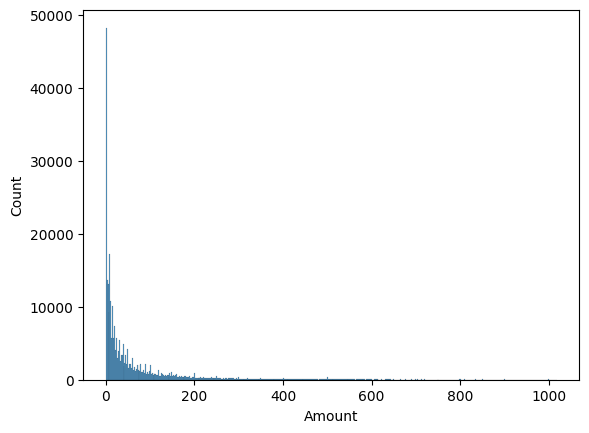

In [155]:
sns.histplot(data, x='Amount')

In [164]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [162]:
a1 = list(credit_fraud.columns[:-1])

In [165]:
data[a1] = scaler.fit_transform(data[a1])

/tmp/ipykernel_1141/2201908941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[a1] = scaler.fit_transform(data[a1])


In [167]:
data.head()

Time        V1        V2        V3        V4        V5        V6   
0  0.000000  0.922638  0.681518  0.841021  0.375357  0.403874  0.597323  \
1  0.000000  0.974385  0.686395  0.785989  0.325921  0.410769  0.583742   
2  0.000006  0.922667  0.663279  0.823300  0.322286  0.401020  0.630684   
3  0.000006  0.930618  0.679899  0.823759  0.256209  0.409552  0.616890   
4  0.000012  0.926726  0.695197  0.818086  0.323522  0.402682  0.588187   

         V7        V8        V9  ...       V21       V22       V23       V24   
0  0.739575  0.786444  0.475312  ...  0.561184  0.472656  0.622227  0.423290  \
1  0.734198  0.786298  0.453981  ...  0.557840  0.425389  0.625831  0.363989   
2  0.748894  0.788042  0.410603  ...  0.565477  0.498125  0.639586  0.313047   
3  0.739541  0.789434  0.414999  ...  0.559734  0.458599  0.620867  0.242154   
4  0.745541  0.782484  0.490950  ...  0.561327  0.499497  0.621767  0.434127   

        V25       V26       V27       V28    Amount  Class  
0  0.507766  0.336462  0.699610  0.340504  0.147047      0  
1  0.510339  0.392856  0.695216  0.341546  0.002644      0  
2  0.477385  0.345417  0.693787  0.339377  0.372147      0  
3  0.542320  0.330588  0.697426  0.342908  0.121376      0  
4  0.485486  0.460239  0.702256  0.347385  0.068786      0  

[5 rows x 31 columns]

In [168]:
# Data preprocessing
from sklearn.feature_selection import SelectKBest, chi2

# Modeling
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report

In [170]:
target = "Class"
X = data[[x for x in data.columns if x!=target]]
y = data[target]

X.shape

(281958, 30)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [173]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression()

In [174]:
def classification_metrics(X, y, estimator):
    ls_scores_roc = cross_val_score(estimator=estimator, X=X, y=y, scoring="roc_auc", n_jobs=-1, cv=4)
    print(f"ROC media: {np.mean(ls_scores_roc):,.2f}, desviación estándar: {np.std(ls_scores_roc)}")

In [175]:
print(classification_report(logistic.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    197164
           1       0.54      0.85      0.66       206

    accuracy                           1.00    197370
   macro avg       0.77      0.93      0.83    197370
weighted avg       1.00      1.00      1.00    197370



In [176]:
print(classification_report(logistic.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84498
           1       0.50      0.88      0.63        90

    accuracy                           1.00     84588
   macro avg       0.75      0.94      0.82     84588
weighted avg       1.00      1.00      1.00     84588

